# TMAC CAPITAL MOMENTUM TRADING STRATEGY

### Thomas McDonnell, Benjamin Panovich and Elie Kostenbaum

***

## INVESTMENT HYPOTHESIS AND GOALS

By using a momentum transformer model to predict when stocks are in uptrends and taking positions based on these predictions (buying when the model predicts a trend, and selling when it predicts the end of a trend), we can achieve excess returns above the benchmark. There are two key assumptions that will make this trading strategy profitable. The first is the assumption that equity trends exist. Our model capitalizes on the assumption that these trends exist and can be capitalized on to make profit. The second assumption is that our transformer model is accurate. It is key to have extensive model testing and validation of the model before using it in a live trading situation, as previous results could be due to overfitting of the model.

The investment universe will consist of a vast array of "big-name" equities: Google, Microsoft, American Airlines, Apple, Ford, General Motors, etc. These equities were chosen as they are extremely liquid, even in large positions that we will be taking, and there is very accurate and available historical data. Hypothetically, if trained with the correct data, this transformer model could be used on any timeseries set of data for any asset class. The transformer will produce daily trade signals and so the portfolio will be very actively managed (algorithmically) and there will be constant buying and selling. Transaction fees will be calculated as 0.0020$ per share as that is how much Interactive Brokers pro account charges per share when trading between 300,000 and 3,000,000 shares per month. The back testing period will be between 2020-01-01 and 2023-07-01. The benchmark for this strategy will simply be the S&P 500 as all of the equities in which we are investing are in the index, and it is an example of a more passive rebalancing of the S&P portfolio

The transformer model was created using Keras and TensorFlow with an Adam optimizer and a binary-cross entropy loss function. This is the ideal transformer framework when dealing with binary model output. To ensure accuracy of the model and lack of overfitting, instead of inputting price data we input stock returns, and standardized each return by subtracting the mean and dividing by the standard deviation. The data that is input into the transformer is a large array, where each data point is an array itself of the previous 10 days of standardized returns, with the dependent variable being a 1 or 0 corresponding to whether the equity is in an uptrend or not. 

One of the key aspects of this strategy is how to define a trend. For the initial phase of this trading strategy, we will only focus on uptrends to avoid shorting costs. The chosen way for our model is to define two moving averages (short and long), and when the short moving average has a certain amount of consecutive days in a row being higher than the long average, the stock is in a trend. The specific numbers used for our current model is a 10 day moving average and a 50 day moving average, and when the 10 day has 15 consecutive days in a row where it is higher than the 50 day moving average, the stock is said to be in a trend. By defining a trend this way, a large dataset was created with years of stock prices for our 12 different equities, and a trend column for each equity that is either a 1 (stock in a trend) or a 0 (stock not in a trend). After standardizing and manipulating it as mentioned above, the data is ready to train the model.

The way to use this model in our trading strategy is simple: buy when there is a trend prediction and sell when the trend prediction is over. Using data from our back testing period, we will input standardized returns and the model will predict whether the stock will be in a trend tomorrow, or whether there will be no trend. By doing this all at once we create a large dataset of trade signals without any forward looking bias, as the only data it has processed is the data up until the trading day. -1 signals (sells) will be created when the model no longer predicts a trend after previous day(s) of predicting a trend. If one wanted to take the strategy forwards, one could have 3 outputs of the model, 1, 0 and -1 for upwards trend, no trend and downwards trend. For now, we are only focusing on upward trends, so every sell signal will always be created after a buy signal. The initial capital for the back test will be 10,000,000$, and each equity will have 1/(amount of tickers + 5) (+5 to ensure if we have big position swings that we never have negative cash) of which it is allotted. Each trade will be the size of the entire capital allotted to the equity.


## OPTIMIZATION

When looking to optimize a portfolio, there are many variables to consider. Some may argue that optimizing total return is the best, others may argue that it is minimizing variance, so for our strategy we will optimize at a mid point, sharpe ratio. It is important to generate alpha but optimizing on return will bring up potential trouble in a live trading session as the model may make super high variance trades. By maximizing our sharpe ratio we will insure that our model is looking to generate trades that produce alpha yet don't make our portfolio extremely variable.

There are many parameters in our deep learning model along with trend parameters on which we must optimize. For the model, the framework parameters have been set yet the amount of epochs and batch size can be optimized. Along with the deep learning parameters, we have our moving average parameters for trend definition. Below is a table of our parameters on which to optimize, what the range is, and what their step size is.


| Variable | Range    |
|----------|----------|
| Epochs   | [5, 10, 15]   |
| batch size   | [16, 32, 64, 128] |
| short MA | [5, 10, 15] |
| long MA | [40, 45, 50, 55, 60]|

The optimization method that we will use is a random search. Ideally, a grid search would be conducted to try every possible combination of parameters, yet with 180 total combinations of parameters and a computationally expensive model, it will take too much time. A random search will be conducted using 30 random combinations of the 180 parameters. As mentioned, the optimization output will be the model with the highest sharpe ratio. 

### TRANSFORMER MODEL FRAMEWORK

In [1]:
import numpy as np
import datetime
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split
import tensorflow as tf
from sklearn.model_selection import train_test_split
from empyrical import sharpe_ratio
import statsmodels.api as sm
from tensorflow import keras
import quandl
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
from tqdm import tqdm
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import Adam
import random

In [2]:
class TransformerEncoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super(TransformerEncoderLayer, self).__init__()

        self.mha = tf.keras.layers.MultiHeadAttention(num_heads=num_heads, key_dim=d_model)
        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.ffn = tf.keras.Sequential([
            tf.keras.layers.Dense(dff, activation='relu'),
            tf.keras.layers.Dense(d_model)
        ])
        self.dropout2 = tf.keras.layers.Dropout(rate)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

    def call(self, inputs, training=False):
        attn_output = self.mha(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)

        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        out2 = self.layernorm2(out1 + ffn_output)

        return out2

class TransformerModel(tf.keras.Model):
    def __init__(self, num_layers, d_model, num_heads, dff, input_shape, rate=0.1):
        super(TransformerModel, self).__init__()

        self.d_model = d_model
        self.num_layers = num_layers

        self.embedding = tf.keras.layers.Dense(d_model, input_shape=input_shape, name='input_embedding')
        self.dropout = tf.keras.layers.Dropout(rate)

        self.encoder_layers = [TransformerEncoderLayer(d_model, num_heads, dff, rate) for _ in range(num_layers)]

        self.final_layer = tf.keras.layers.Dense(1, activation='sigmoid')

    def call(self, inputs, training=False):
        x = self.embedding(inputs)
        x = self.dropout(x, training=training)

        for i in range(self.num_layers):
            x = self.encoder_layers[i](x, training=training)

        x = self.final_layer(x)

        return x
    
def sliding_window(arr, window_size):
    n_rows = arr.shape[0] - window_size + 1
    n_cols = arr.shape[1]
    res = np.zeros((n_rows, n_cols, window_size))
    for i in range(n_rows):
        res[i,:,:] = arr[i:i+window_size,:].T
    return res

### Optimization Function

In [3]:
def optimize(parameter_grid, opt = True):
    tickers = ['GOOG', 'MSFT', 'AA', 'AAPL', 'F', 'GM', 'NKE', 'ORCL', 'META', 'UNH', 'LLY', 'XOM', 'CVX', 'V', 'PEP', 'KO', 'CRM', 'NVDA', 'TSLA', 'AMD' ]
    key = 'uoxc6V3s61czWuHoGLcs'  #Your API key here for quandl
    x = {}
    model = " "
    epochs = int(parameter_grid['epochs'])
    batch_size = int(parameter_grid['batch_size'])
    short_MA = int(parameter_grid['short_moving_avg'])
    long_MA = int(parameter_grid['long_moving_avg'])
    for ticker in (tickers):
        df =  quandl.get_table('QUOTEMEDIA/PRICES', ticker = [ticker], api_key = key,
                            date = { 'gte': '2010-01-01', 'lte': '2018-01-01' }, 
                            paginate=True)
        df = df.set_index('date')
        df = df[['adj_close', 'adj_volume']]

        df[ticker + ' returns'] = (df[['adj_close']].pct_change()*100).dropna()

        rolling_avg = pd.DataFrame(df['adj_close'].rolling(long_MA).mean().shift(-long_MA))
        rolling_avg[ticker + ' Small MA'] =(df['adj_close'].rolling(short_MA).mean().shift(-short_MA))
        data = pd.merge(df, rolling_avg, left_index=True, right_index = True)
        data = data.dropna()
        data = data.rename(columns = {'adj_close_x': ticker + ' price', 'adj_close_y': ticker + ' Big MA'})

        trend = []
        for i in range(len(data)):
            small_ma_count = sum(data[ticker + " Small MA"].iloc[i-15:i] > data[ticker + " Big MA"].iloc[i-15:i])
            if small_ma_count == 15:
                trend.append(1)
            else:
                trend.append(0)

        data["trend"] = trend
        data['trend'] = data['trend'].shift(-1)
        data = data.dropna()
        data = data[[ticker + ' returns', 'trend']]
        x[ticker] = data

    num_layers = 4
    d_model = 64
    num_heads = 8
    dff = 256
    input_shape = (None, 1)
    rate = 0.5

    # Instantiate your TransformerModel class
    model = TransformerModel(num_layers, d_model, num_heads, dff, input_shape, rate)

    # Compile your model with a binary crossentropy loss and Adam optimizer
    model.compile(optimizer='Adam',
                loss='binary_crossentropy',
                metrics=['accuracy'])
    
    final_y = np.empty((0,1))
    final_x = np.empty((0,1,10))
    for ticker in tickers:
        df = x[ticker]
        df[ticker + ' returns'] = (df[ticker + ' returns'] - df[ticker + ' returns'].mean())/df[ticker + ' returns'].std()
        window_size = 10
        train_x = sliding_window(df[[ticker + ' returns']].values, window_size)
        train_y = df['trend'].values
        train_y = np.reshape(train_y[window_size-1:], (len(train_y)-window_size+1, 1))
        final_y = np.concatenate((final_y, train_y), axis = 0)
        final_x = np.concatenate((final_x, train_x), axis = 0)


    train_size = int(len(final_x) * 0.8)
    train_x = final_x[:train_size]
    val_x = final_x[train_size:]
    train_y = final_y[:train_size]
    val_y = final_y[train_size:]


    model.fit(train_x, train_y, validation_data=(val_x, val_y), epochs=epochs, batch_size=batch_size)

    preds = model.predict(val_x)
    last_entry = preds[:, -1, 0]

    # create a pd dataframe with the last entry in each row
    df = pd.DataFrame({'prediction': last_entry})
    df = df.round()
    cm = confusion_matrix(val_y, df)
    if (df.eq(0).all().all() or df.eq(1).all().all()):
        if opt != True:
            print('Model is overfit, run code again')
        return 0
    

    #get historical prices
    historical_prices = quandl.get_table('QUOTEMEDIA/PRICES', ticker = ['AMZN'], api_key = key,
                            date = { 'gte': '2018-01-01', 'lte': '2023-07-01' }, 
                            paginate=True)
    historical_prices = historical_prices[['adj_close', 'date']]
    historical_prices.columns = ['AMZN price', 'date']
    historical_prices = historical_prices.set_index('date')
    historical_prices['AMZN returns'] = (historical_prices[['AMZN price']].pct_change()*100).dropna()
    historical_returns = historical_prices[['AMZN returns']]
    historical_prices = historical_prices[['AMZN price']]
    for ticker in (tickers):
        if ticker != 'AMZN':
            df =  quandl.get_table('QUOTEMEDIA/PRICES', ticker = [ticker], api_key = key,
                                date = { 'gte': '2018-01-01', 'lte': '2023-07-01' }, 
                                paginate=True)
            df = df[['adj_close', 'date']]
            df.columns = [ticker + ' price', 'date']
            df= df.set_index('date')
            df[ticker + ' returns'] = (df[[ticker + ' price']].pct_change()*100).dropna()
            pr = df[[ticker + ' price']]
            df = df[[ticker + ' returns']]
            historical_returns = pd.merge(historical_returns, df, left_index=True, right_index=True)
            historical_prices = pd.merge(historical_prices, pr, left_index = True, right_index = True  )

    #standardization
    historical_returns = (historical_returns - historical_returns.mean()) / historical_returns.std()
    historical_returns = historical_returns.dropna()

    #miscelaneous
    historical_returns = historical_returns.iloc[::-1]
    historical_prices = historical_prices.iloc[::-1]
    historical_prices = historical_prices.iloc[:-1]
    
    tickers.append('AMZN')

    #create signals using model
    for ticker in tickers:
        tick_data = historical_returns[[ticker + ' returns']]
        test = sliding_window(tick_data.values, window_size)
        preds = model.predict(test)
        last_entry = preds[:, -1, 0]
        df = pd.DataFrame({'prediction': last_entry})
        df = df.round()
        df.index = historical_returns[9:].index
        last_signal = 0
        for i, row in df.iterrows():
            if row['prediction'] == 1 and last_signal == 0:
                # if the current value is 1 and the last signal was 0, set the signal to 1 (buy)
                df.at[i, ticker + ' signals'] = 1
                last_signal = 1
            elif row['prediction'] == 0 and last_signal == 1:
                # if the current value is 0 and the last signal was 1, set the signal to -1 (sell)
                df.at[i, ticker + ' signals'] = -1
                last_signal = 0
        df = df.fillna(0)
        df = df[str(ticker) + ' signals']
        historical_prices = pd.merge(historical_prices,df, left_index=True, right_index = True)

    portfolio = pd.DataFrame(columns = tickers)
    portfolio = portfolio.reindex(historical_prices.index)
    portfolio['Cash'] = 0
    portfolio['Total Value'] = 0
    portfolio['Date'] = portfolio.index
    portfolio['Previous Date'] = portfolio["Date"].shift(1)
    portfolio = portfolio.fillna(0)

    total_transactions = 0
    for date in historical_prices.index:
        if date == datetime.datetime(2018,1,16):
            pass
        else:
            prev = portfolio.loc[date, 'Previous Date']
            if date == datetime.date(2018, 1, 17):
                portfolio.loc[date, 'Cash'] = 10_000_000
            else:
                portfolio.loc[date, 'Cash'] = portfolio.loc[prev, 'Cash']
            for tick in tickers:
                if historical_prices.loc[prev, str(tick) + ' signals'] == 1.0:
                    total_transactions += 1
                    if date == datetime.datetime(2018,1,17):
                        shares_to_buy = 10_000_000/len(tickers)/historical_prices.loc[date, str(tick) + ' price']
                    else:
                        shares_to_buy = ((portfolio.loc[prev, 'Total Value']/(len(tickers)+5))/historical_prices.loc[date, str(tick) + ' price'])
                    portfolio.loc[date, str(tick)] += shares_to_buy
                    portfolio.loc[date, 'Cash'] -= (portfolio.loc[date, str(tick)]*historical_prices.loc[date, str(tick) + ' price'])
            
                if historical_prices.loc[prev, str(tick) + ' signals'] == 0:
                    if date != datetime.datetime(2018,1,17):
                        portfolio.loc[date, str(tick)] = portfolio.loc[prev, str(tick)]
                if historical_prices.loc[prev, str(tick) + ' signals'] == -1:
                    total_transactions += 1
                    val = portfolio.loc[prev, str(tick)] * historical_prices.loc[date, tick + ' price']
                    transact_cost = .002 * portfolio.loc[prev, tick]
                    portfolio.loc[date, 'Cash'] += val - transact_cost
                    portfolio.loc[date, tick] = 0
                portfolio.loc[date, 'Total Value'] += (portfolio.loc[date, str(tick)]*historical_prices.loc[date, str(tick) + ' price'])
            portfolio.loc[date, 'Total Value'] += portfolio.loc[date, 'Cash']
    portfolio = portfolio.drop(portfolio.index[0])

    spy = quandl.get_table('QUOTEMEDIA/PRICES', ticker = ['SPY'], api_key = key,
                        date = { 'gte': '2018-01-01', 'lte': '2023-07-01' }, 
                        paginate=True)
    spy = spy[['adj_close', 'date']]
    spy = spy[::-1]
    spy.index = spy['date']
    first_day_price = spy.iloc[0]['adj_close']
    shares = 10_000_000/first_day_price
    spy['position'] = shares * spy['adj_close']

    first_date = portfolio.index[0]
    last_date = portfolio.index[-1]
    spy = spy.loc[datetime.datetime(2018, 1, 17):datetime.datetime(2023, 6, 29)]

    
    portfolio['Daily Return'] = portfolio['Total Value'].pct_change()
    sharpe = portfolio['Daily Return'].mean()/portfolio['Daily Return'].std()
    if opt == True:
        return sharpe
    else:
        return portfolio



In [4]:
param_space = {
    'epochs': [5, 10, 15],
    'batch_size': [16, 32, 64, 128],
    'short_moving_avg': [5, 10, 15],
    'long_moving_avg': [40, 45, 50, 55, 60],
}

num_random = 3

sharpe = pd.DataFrame(index = range(num_random), columns = ['batch size', 'epochs', 'short MA', 'long MA', 'Sharpe'])
for i in range(num_random):
    params = {param: random.choice(values) for param, values in param_space.items()}
    
    sharpes_each = optimize(params)
    sharpe.loc[i, 'batch_size'] = params['batch_size']
    sharpe.loc[i, 'epochs'] = params['epochs']
    sharpe.loc[i, 'short_moving_avg'] = params['short_moving_avg']
    sharpe.loc[i, 'long_moving_avg'] = params['long_moving_avg']  
    sharpe.loc[i, 'Sharpe'] = sharpes_each


Epoch 1/10
442/442 [==============================] - 7s 9ms/step - loss: 0.6725 - accuracy: 0.5748 - val_loss: 0.6513 - val_accuracy: 0.5736
Epoch 2/10
442/442 [==============================] - 4s 8ms/step - loss: 0.6474 - accuracy: 0.5916 - val_loss: 0.6301 - val_accuracy: 0.6119
Epoch 3/10
442/442 [==============================] - 4s 8ms/step - loss: 0.6416 - accuracy: 0.6037 - val_loss: 0.6188 - val_accuracy: 0.5980
Epoch 4/10
442/442 [==============================] - 3s 8ms/step - loss: 0.6401 - accuracy: 0.5995 - val_loss: 0.6371 - val_accuracy: 0.6003
Epoch 5/10
442/442 [==============================] - 4s 8ms/step - loss: 0.6406 - accuracy: 0.5915 - val_loss: 0.6329 - val_accuracy: 0.5842
Epoch 6/10
442/442 [==============================] - 4s 8ms/step - loss: 0.6399 - accuracy: 0.5924 - val_loss: 0.6223 - val_accuracy: 0.6081
Epoch 7/10
442/442 [==============================] - 4s 8ms/step - loss: 0.6377 - accuracy: 0.5997 - val_loss: 0.6156 - val_accuracy: 0.6143
Epoch 

In [5]:
sharpe = sharpe[['batch_size', 'epochs', 'short_moving_avg', 'long_moving_avg', 'Sharpe']]
sharpe['Sharpe'] = sharpe['Sharpe'].astype(float)
max_sharpe_row = sharpe.loc[sharpe['Sharpe'].idxmax()]
result_dict = max_sharpe_row.to_dict()
result_dict.pop('Sharpe', None)
overfit = True
# Get a non overfit model (may take a few loops to make)
while overfit == True:
    portfolio = optimize(result_dict, opt = False)
    if type(portfolio) == int:
        #reduce epochs
        result_dict['epochs'] -= 1
    else:
        overfit = False

Epoch 1/10
442/442 [==============================] - 8s 11ms/step - loss: 0.6696 - accuracy: 0.5758 - val_loss: 0.6358 - val_accuracy: 0.5961
Epoch 2/10
442/442 [==============================] - 4s 9ms/step - loss: 0.6476 - accuracy: 0.5899 - val_loss: 0.6362 - val_accuracy: 0.5996
Epoch 3/10
442/442 [==============================] - 4s 9ms/step - loss: 0.6431 - accuracy: 0.5926 - val_loss: 0.6236 - val_accuracy: 0.5784
Epoch 4/10
442/442 [==============================] - 4s 10ms/step - loss: 0.6396 - accuracy: 0.5964 - val_loss: 0.6265 - val_accuracy: 0.5808
Epoch 5/10
442/442 [==============================] - 4s 9ms/step - loss: 0.6386 - accuracy: 0.5962 - val_loss: 0.6377 - val_accuracy: 0.5958
Epoch 6/10
442/442 [==============================] - 4s 9ms/step - loss: 0.6369 - accuracy: 0.5984 - val_loss: 0.6215 - val_accuracy: 0.6019
Epoch 7/10
442/442 [==============================] - 4s 9ms/step - loss: 0.6357 - accuracy: 0.6024 - val_loss: 0.6172 - val_accuracy: 0.6091
Epoc

### Optimal Parameters

In [6]:
print(result_dict)

{'batch_size': 64.0, 'epochs': 10, 'short_moving_avg': 5.0, 'long_moving_avg': 50.0}


Above are the optimal parameters using our random search. The model that utilizes these parameters has been run and we will now evaluate our portfolio for the given model. Not that if the amount of epochs are not in the values tested (5, 10, 15) that is because the model won't run the same everytime, and occasionally it will entirely overfit a model output to be all trues or all false. If this happens to our optimal model, we reduce the amount of epochs and run it again.

***

## EVALUATING BACKTESTED RESULTS

In [7]:
key = 'uoxc6V3s61czWuHoGLcs'  #Your API key here for quandl
spy = quandl.get_table('QUOTEMEDIA/PRICES', ticker = ['SPY'], api_key = key,
                        date = { 'gte': '2018-01-01', 'lte': '2023-07-01' }, 
                        paginate=True)
spy = spy[['adj_close', 'date']]
spy = spy[::-1]
spy.index = spy['date']
first_day_price = spy.iloc[0]['adj_close']
shares = 10_000_000/first_day_price
spy['position'] = shares * spy['adj_close']

first_date = portfolio.index[0]
last_date = portfolio.index[-1]
spy = spy.loc[datetime.datetime(2018, 1, 17):datetime.datetime(2023, 6, 29)]

### METRICS

In [8]:
first_date = portfolio.index[0]
last_date = portfolio.index[-1]
spy = spy.loc[datetime.datetime(2018, 1, 17):datetime.datetime(2023, 6, 29)]
metrics = pd.DataFrame(index = ['Momentum', 'Benchmark'], columns = ['Total Return',  'Max Drawdown', 'Sharpe Ratio', 'Tracking Error', 'Information Ratio', 'Market Beta', 'Treynor Ratio', 'Jensens Alpha'])
metrics.loc['Momentum', 'Total Return'] = (portfolio.loc[last_date, 'Total Value'] - portfolio.loc[first_date, 'Total Value'])/portfolio.loc[first_date, 'Total Value']
metrics.loc['Benchmark', 'Total Return'] = (spy.loc[last_date, 'position'] - spy.loc[first_date, 'position'])/spy.loc[first_date, 'position']
portfolio['Cumulative Max'] = portfolio['Total Value'].cummax()
portfolio['Drawdown'] = (portfolio['Total Value'] - portfolio['Cumulative Max'])/portfolio['Cumulative Max']
spy['Cumulative Max'] = spy['position'].cummax()
spy['Drawdown'] = (spy['position'] - spy['Cumulative Max'])/spy['Cumulative Max']
metrics.loc['Momentum','Max Drawdown'] = portfolio['Drawdown'].min()
metrics.loc['Benchmark', 'Max Drawdown'] = spy['Drawdown'].min()
portfolio['Daily Return'] = portfolio['Total Value'].pct_change()
metrics.loc['Momentum','Sharpe Ratio'] = portfolio['Daily Return'].mean()/portfolio['Daily Return'].std()
spy['Daily Return'] = spy['position'].pct_change()
metrics.loc['Benchmark','Sharpe Ratio'] = spy['Daily Return'].mean()/spy['Daily Return'].std()
metrics.loc['Momentum', 'Tracking Error'] = (portfolio['Daily Return'] - spy['Daily Return']).std() * 100
metrics.loc['Momentum', 'Information Ratio'] = (metrics.loc['Momentum', 'Total Return'] - metrics.loc['Benchmark', 'Total Return'])/(metrics.loc['Momentum', 'Tracking Error'])
X = sm.add_constant(spy['Daily Return'].fillna(0))
y = portfolio['Daily Return'].fillna(0)
model = sm.OLS(y,X).fit()
metrics.loc['Momentum', 'Market Beta'] = model.params['Daily Return']
rf = .30819
metrics.loc['Momentum', 'Treynor Ratio'] = (metrics.loc['Momentum', 'Total Return'] - rf)/metrics.loc['Momentum', 'Market Beta']
metrics.loc['Momentum', 'Jensens Alpha'] = metrics.loc['Momentum', 'Total Return'] - (rf + metrics.loc['Momentum', 'Market Beta']*(metrics.loc['Benchmark', 'Total Return'] - rf))

metrics

,Total Return,Max Drawdown,Sharpe Ratio,Tracking Error,Information Ratio,Market Beta,Treynor Ratio,Jensens Alpha
Momentum,1.171429,-0.231015,0.068819,0.917974,0.491085,0.479729,1.799431,0.665382
Benchmark,0.720626,-0.336999,0.036487,NaN,NaN,NaN,NaN,NaN


In [9]:
def tailMetrics(returns, quantile=.05, relative=False, mdd=True):
    metrics = pd.DataFrame(index=returns.columns)
    metrics['Skewness'] = returns.skew()
    metrics['Kurtosis'] = returns.kurtosis()

    VaR = returns.quantile(quantile)
    CVaR = (returns[returns < returns.quantile(quantile)]).mean()

    if relative:
        VaR = (VaR - returns.mean())/returns.std()
        CVaR = (CVaR - returns.mean())/returns.std()

    metrics[f'VaR ({quantile})'] = VaR
    metrics[f'CVaR ({quantile})'] = CVaR
    return metrics

tailMetrics(portfolio[['Daily Return']])

,Skewness,Kurtosis,VaR (0.05),CVaR (0.05)
Daily Return,-0.498557,3.285207,-0.014184,-0.020844


As mentioned, this strategy seems somewhat safer than the benchmark and doesn't seem to have too steep of drawdowns. The VaR or value at risk for daily returns with a .05 quantile is -.011 which is not a super scary or detrimental return. Conditional VaR is a slightly lower and more extreme return yet still less than a 2% drawdown in one day.

***

## PERFORMANCE ATTRIBUTION

As mentioned previously, the benchmark is the SPY ETF during this period.

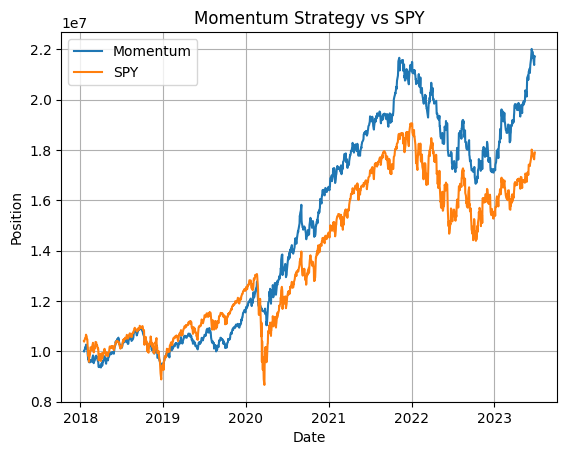

In [10]:
plt.plot(portfolio['Total Value'], label = 'Momentum')
plt.plot(spy['position'], label = 'SPY')
plt.title('Momentum Strategy vs SPY')
plt.xlabel('Date')
plt.ylabel('Position')
plt.grid()
plt.legend()
plt.show()

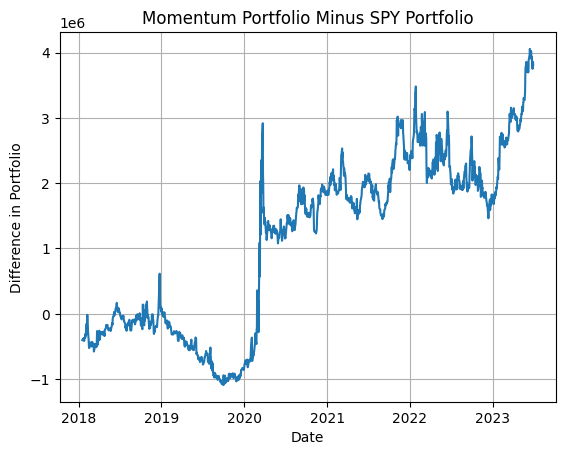

In [11]:
plt.plot(portfolio['Total Value'] - spy['position'])
plt.title('Momentum Portfolio Minus SPY Portfolio')
plt.ylabel('Difference in Portfolio')
plt.xlabel('Date')
plt.grid()

The attribution model which is selected is a fama french comparison. We will regress our returns with the Mkt-RF factor, aka excess returns. We will examine the beta and the r^2 to determine how closely associated our returns are with the market returns. Then, we will do a fama french risk decomposition to see how our returns compare to thte SMB and HML factors.

In [12]:
data = pd.read_excel("C:/Users/thoma/Downloads/fama.xlsx")
data = data.rename(columns={'Unnamed: 0': 'Date'})
data = data.set_index('Date')
data = data.loc[20180117:20230629]
data.index = pd.to_datetime(data.index, format = '%Y%m%d')

### CAPM

In [13]:
X = (data['Mkt-RF'].fillna(0))
y = portfolio['Daily Return'].fillna(0)*100
model = sm.OLS(y,X).fit()
capm = pd.DataFrame(columns = ['value'], index = ['Beta', 'R^2'])
capm.loc['Beta', 'value'] = model.params['Mkt-RF']
capm.loc['R^2', 'value'] = model.rsquared
capm

,value
Beta,0.466181
R^2,0.53326


### HML

In [14]:
X = (data['HML'].fillna(0))
y = portfolio['Daily Return'].fillna(0)*100
model = sm.OLS(y,X).fit()
hml = pd.DataFrame(columns = ['value'], index = ['Beta', 'R^2'])
hml.loc['Beta', 'value'] = model.params['HML']
hml.loc['R^2', 'value'] = model.rsquared
hml

,value
Beta,-0.104523
R^2,0.016855


### SMB

In [15]:
X = (data['SMB'].fillna(0))
y = portfolio['Daily Return'].fillna(0)*100
model = sm.OLS(y,X).fit()
smb = pd.DataFrame(columns = ['value'], index = ['Beta', 'R^2'])
smb.loc['Beta', 'value'] = model.params['SMB']
smb.loc['R^2', 'value'] = model.rsquared
smb

,value
Beta,0.259761
R^2,0.043124


Ideally, a portfolios return time series is uncorrelated with any of these factors, to show that the returns are being generated from a good strategy and not market movement. As seen above, none of the betas are above .4, with the HML beta being practically 0. The market r^2 value is quite high which shows that a good portion of the variance in daily returns can be explained by market returns. Ideally, this number would be lower but there is still a lot of variance that can be explained (or not explained) by other factors.

In the future, we may look to adjust our asset selection or position sizings to attempt to lower the variance explained by the market returns. 